In [1]:
#pip3 install google.colab
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

###  Libraries

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

import torch

import os
import sys

from Autoencoder import Autoencoder, CD_Autoencoder
from Datasets.Datasets_Functions import *
from Visualization import Visualization
from Evaluations.Evaluation import Evaluator
from General_Functions import General_Functions

/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Global Variables

In [3]:
path_to_module = './' # 'C:\\Users\\PAPASOFT INC\\Desktop\\SOFT_SIL'
sys.path.append(path_to_module)
os.environ['OMP_NUM_THREADS'] = '6'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

### Visualization

In [4]:
visualization = Visualization()

### ***LOAD DATASET***

In [5]:
hashmap_path = path_to_module + 'Datasets/'
hashmap = get_hashmap(hashmap_path)
print(hashmap.keys())

dataset_name = 'emnist_balanced_digits'
dataset_properties = hashmap[dataset_name]
print(dataset_properties)

batch_size = dataset_properties['batch_size']
n_clusters = dataset_properties['n_clusters']
dataloader, input_dim, data_np, labels = function_get_dataset(dataset_name, dataset_properties)

print('Data_Shape is:', input_dim)
print('Batches Number is:', len(dataloader))

dict_keys(['tcga', 'emnist_balanced_letters', 'emnist_mnist', 'emnist_balanced_digits', 'dermatology', 'ecoil', 'iris', 'rings', 'wine', 'australian', 'moons', 'squeezed_gauss', 'gauss_densities', 'pendigits', 'fashionmnist', '3dspheres', '20_newsgroups', 'coil20', 'cifar10', 'stl10', 'r15', 'r3'])
{'batch_size': 256, 'n_clusters': 10, 'module_name': 'Datasets.Datasets'}
Data_Shape is: 1
Batches Number is: 110


### Parameters

In [6]:
# Latent Dimension, Number of Channels and Negative Slope
latent_dim = 10
n_channels = 1
n_clusters = dataset_properties['n_clusters']

# Batch Size and Number of Clusters
batch_size = dataset_properties['batch_size']
negative_slope = 0

# Pre-Training Epochs and Learning Rate
n_pret_epochs = 100
pret_lr = 1e-3

# Lamdas, Training Epochs and Learning Rate
n_epochs = 100
lr = 5e-4
sil_lambda = 0.02
entr_lambda = 0.02

kmeans_initialization = True
pretrain = False
is_MLP_AE = False

### Create Autoencoder Model

In [7]:
if is_MLP_AE:
    autoencoder = Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()
else:
    autoencoder = CD_Autoencoder(device=device, n_clusters=n_clusters, input_dim=input_dim, latent_dim=latent_dim, negative_slope=negative_slope, n_channels=n_channels)
    autoencoder.set_general_training_variables(dataloader=dataloader, batch_size=batch_size)
    autoencoder.set_pretraining_variables(n_pret_epochs=n_pret_epochs, pret_lr=pret_lr)
    autoencoder.set_training_variables(n_epochs=n_epochs, lr=lr, sil_lambda=sil_lambda, entr_lambda=entr_lambda)
    autoencoder.set_path_variables(path_to_module=path_to_module, dataset_name=dataset_name)
    autoencoder.set_path()

autoencoder = autoencoder.to(device)

In [8]:
autoencoder

CD_Autoencoder(
  (encoder_model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyReLU(negative_slope=0, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=10, bias=True)
    (11): Tanh()
    (12): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cluster_model): Sequential(
    (0): RBF()
  )
  (decoder_model): Sequential(
    (0): Linear(in_feature

### Pretrain Autoencoder

In [9]:
if(pretrain):
    autoencoder.pretrain_autoencoder()
    autoencoder.save_pretrained_weights()
else:
    model_save_path = autoencoder.data_dir_path + '/Weigths/autoencoder_weights.pth'
    autoencoder.load_state_dict(torch.load(model_save_path))

### Initialize the clustering layer using k-means

In [10]:
n_inits = 100
if kmeans_initialization: autoencoder.kmeans_initialization(n_inits)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08063cfa30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08064393f0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08063cfa30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08064395a0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0806439510>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08063cfa30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0806439510>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08064395a0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0806439090>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0806439630>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08063cfa30>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f08064395a0>
Traceback (most recent call last):
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


ACC: 0.66 PUR: 0.70 NMI: 0.66 ARI: 0.53


### Train Autoencoder

In [11]:
autoencoder.set_training_variables(n_epochs=20, lr=5e-4, sil_lambda=0.02, entr_lambda=0.02)
latent_data, labels, clustering = autoencoder.train_autoencoder()
cluster_centers = autoencoder.get_cluster_centers().cpu().detach().numpy()

Ep: 0 Rec L: 1.1068 Cl L: 2.2734 Entropy: 7.1377 SSil: -3.6694 SIL: 0.0000 ACC: 0.66 PUR: 0.69 NMI: 0.65 ARI: 0.53
Ep: 1 Rec L: 1.1334 Cl L: 2.2987 Entropy: 7.0065 SSil: -4.9349 SIL: 0.0000 ACC: 0.64 PUR: 0.68 NMI: 0.63 ARI: 0.50
Ep: 2 Rec L: 1.1352 Cl L: 2.3078 Entropy: 6.9579 SSil: -5.3887 SIL: 0.0000 ACC: 0.64 PUR: 0.67 NMI: 0.62 ARI: 0.48
Ep: 3 Rec L: 1.1473 Cl L: 2.3159 Entropy: 6.9288 SSil: -5.7929 SIL: 0.0000 ACC: 0.63 PUR: 0.66 NMI: 0.61 ARI: 0.47
Ep: 4 Rec L: 1.1286 Cl L: 2.3240 Entropy: 6.8998 SSil: -6.1994 SIL: 0.0000 ACC: 0.63 PUR: 0.66 NMI: 0.61 ARI: 0.46
Ep: 5 Rec L: 1.1400 Cl L: 2.3367 Entropy: 6.8663 SSil: -6.8336 SIL: 0.0000 ACC: 0.63 PUR: 0.66 NMI: 0.60 ARI: 0.46
Ep: 6 Rec L: 1.1344 Cl L: 2.3538 Entropy: 6.8064 SSil: -7.6919 SIL: 0.0000 ACC: 0.63 PUR: 0.67 NMI: 0.61 ARI: 0.48
Ep: 7 Rec L: 1.1622 Cl L: 2.3823 Entropy: 6.6682 SSil: -9.1130 SIL: 0.0000 ACC: 0.66 PUR: 0.70 NMI: 0.64 ARI: 0.52
Ep: 8 Rec L: 1.2881 Cl L: 2.4132 Entropy: 6.2047 SSil: -10.6608 SIL: 0.0000 ACC:

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28010 samples in 0.024s...


/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/geo/anaconda3/envs/gvardakas/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 28010 samples in 1.535s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28010
[t-SNE] Computed conditional probabilities for sample 2000 / 28010
[t-SNE] Computed conditional probabilities for sample 3000 / 28010
[t-SNE] Computed conditional probabilities for sample 4000 / 28010
[t-SNE] Computed conditional probabilities for sample 5000 / 28010
[t-SNE] Computed conditional probabilities for sample 6000 / 28010
[t-SNE] Computed conditional probabilities for sample 7000 / 28010
[t-SNE] Computed conditional probabilities for sample 8000 / 28010
[t-SNE] Computed conditional probabilities for sample 9000 / 28010
[t-SNE] Computed conditional probabilities for sample 10000 / 28010
[t-SNE] Computed conditional probabilities for sample 11000 / 28010
[t-SNE] Computed conditional probabilities for sample 12000 / 28010
[t-SNE] Computed conditional probabilities for sample 13000 / 28010
[t-SNE] Computed conditional probabilities for sample 14000 / 28010

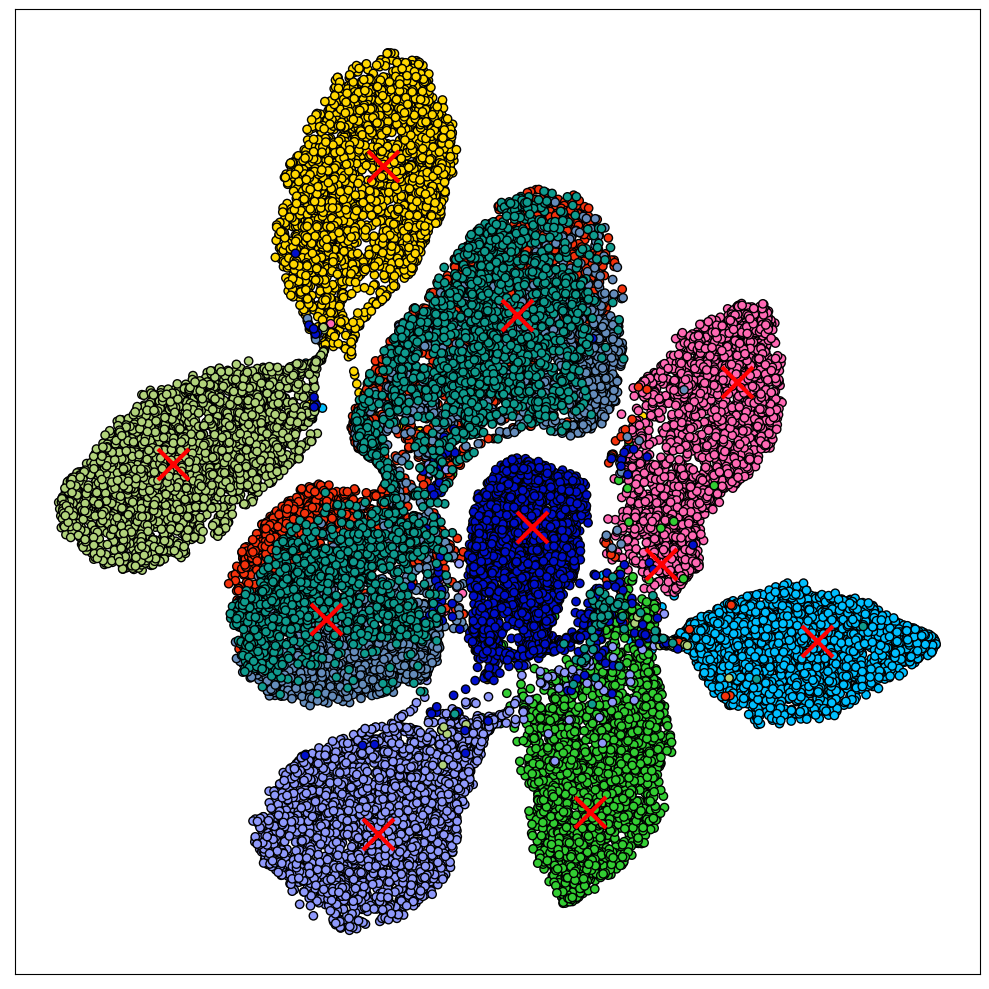

In [12]:
visualization.plot_tsne(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

Directory './Results/emnist_balanced_digits/AE/100_Eps_ld_10_out_10_bs_256_lr_0.0005_sil_lambda_0.02_entr_lambda_0.02/Experiments/No_TSNE' created successfully.


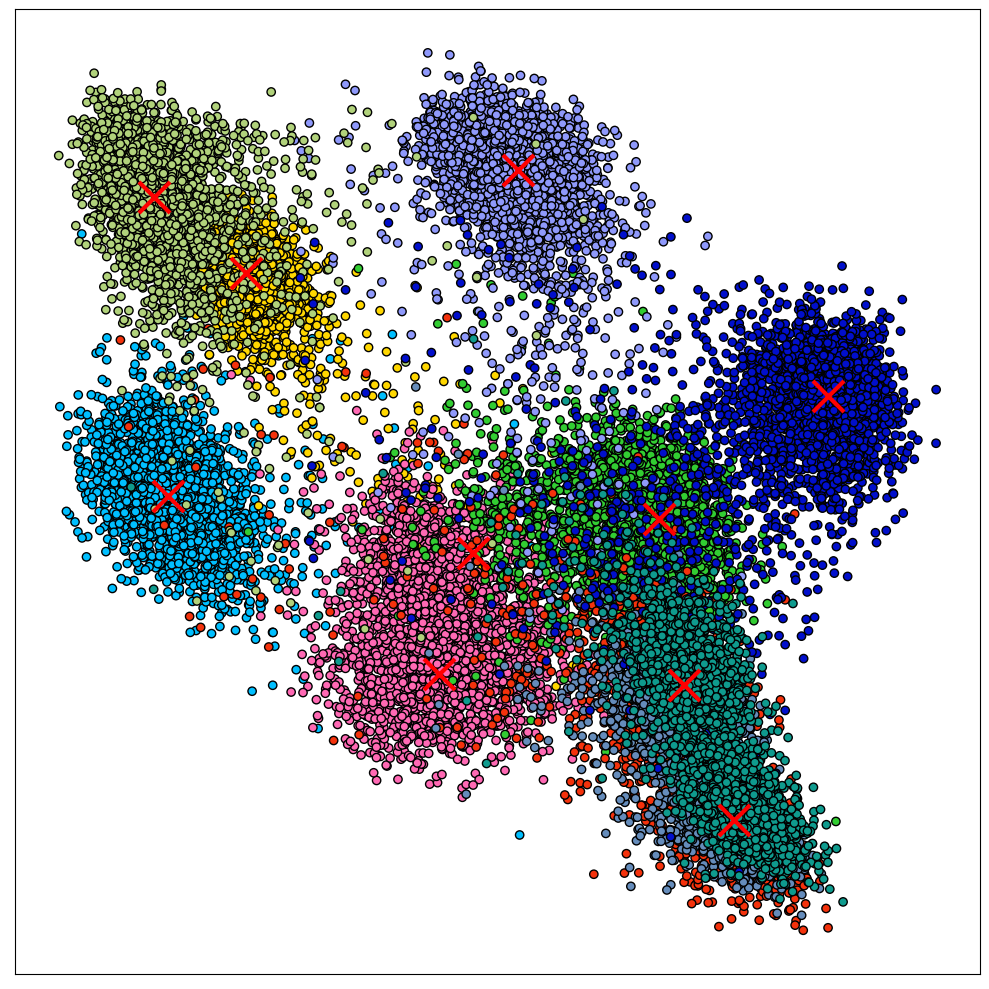

In [13]:
visualization.plot(latent_data, labels, clustering, cluster_centers, autoencoder.data_dir_path)

In [14]:
General_Functions().save_excel(autoencoder.data_dir_path, autoencoder.df_eval)

Directory './Results/emnist_balanced_digits/AE/100_Eps_ld_10_out_10_bs_256_lr_0.0005_sil_lambda_0.02_entr_lambda_0.02' already exists.


/home/geo/Desktop/Soft-Silhouette/General_Functions.py:22: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = workbook
/home/geo/Desktop/Soft-Silhouette/General_Functions.py:26: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
